# Initial analysis
In essence this is a feasibility study for our project.

## Outline
### Part I: Filter Bubbles
Part I aims to relate channels by identifying common commenters between them. For this we need to touch all major datasets. The steps themselves (outlined below) are straight-forward. However, the size of the files increases the complexity. Whenever necessary we read large files sequentially to decrease memory requirements and delete dataframes from memory that are no longer necessary.


Steps
1. Read in Additional Dataset: AllSides News Outlets Media Bias Ranking
2. Query the YouTube API for matching channels
  a. Manually verify
  b. Filter for duplicate matches etc.
3. Match to YouTube channel list from the YouNiverse dataset
4. Filter videos of the relevant channels
5. Filter comments of all relevant videos
6. Find common commenters and draw initial graph

### Part II: Time Series
    
The second part is focusing on the channels we found interesting during our initial analysis. Here we've chosen as hyphotetical points of interest the Fox News channel and compared it's weekly viewings with Donald Trump's approval rate through time. We try to see if there's some particular dates or periods where excists noticeable similarity.

In [2]:
import json
import gzip
import pickle
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import googleapiclient.discovery
from itertools import combinations

## Required files
To run this notebook the following files are required:

```
.
├── data
│   ├── df_channels_en.tsv.gz
│   ├── df_news_youtube.csv
│   ├── df_timeseries_en.tsv.gz
│   ├── publications.json
│   ├── trump_approval_polllist.csv
│   ├── youtube_comments.tsv.gz
│   ├── yt_metadata_en.jsonl.gz
└── initial_analysis.ipynb
```

`trump_approval_pollist.csv` retrieved from FiveThirtyEight (https://projects.fivethirtyeight.com/trump-approval-ratings/)

`publications.json` retrieved from AllSides (https://www.allsides.com/media-bias/ratings)

## Part I: Filter Bubbles

### Step 1
Read in Additional Dataset: AllSides News Outlets Media Bias Ranking

In [2]:
# The media bias rating dataset from Allsides (https://www.allsides.com/media-bias/ratings)
# It rates major and smaller news outlets with their political leaning
with open("data/publications.json") as f:
  raw = json.load(f)

data = [pub["publication"] for pub in raw["allsides_media_bias_ratings"]]
df_publications = pd.DataFrame.from_records(data)
df_news = df_publications[df_publications.source_type == "News Media"].reset_index().drop("index", axis=1)

In [3]:
df_news.head()

,source_name,source_type,media_bias_rating,source_url,allsides_url
0,ABC News (Online),News Media,Lean Left,http://abcnews.go.com/,https://www.allsides.com/news-source/abc-news-...
1,Above The Law,News Media,Lean Left,https://abovethelaw.com/,https://www.allsides.com/news-source/above-law...
2,Abridge News,News Media,Mixed,https://abridgenews.com,https://www.allsides.com/news-source/abridge-n...
3,Adventist Today,News Media,Lean Left,https://atoday.org/,https://www.allsides.com/news-source/adventist...
4,Advocate,News Media,Lean Left,https://www.advocate.com/,https://www.allsides.com/news-source/advocate-...


### Step 2
Query the YouTube API for matching channels

In [ ]:
YOUTUBE_API_KEY = ""

api_service_name = "youtube"
api_version = "v3"
youtube = googleapiclient.discovery.build(
                api_service_name, 
                api_version, 
                developerKey=YOUTUBE_API_KEY)

def get_channel_from_youtube_api(query):
  """Queries the youtube API and return first matching channel

  Args:
    query: search string

  Returns:
    [channelID, channelTitle, channelDescription]
  """
  request = youtube.search().list(
      part="snippet",
      maxResults=25,
      q=query,
      type="channel"  # only search for channels
  )

  res = request.execute()

  # skip if no result is found
  if len(res["items"]) == 0:
    return []
  
  # consider the first result - we manually verify this later
  result = res["items"][0]["snippet"]

  # return basic info, this helps the manual verification
  return [result["channelId"], result["title"], result["description"]]

In [ ]:
youtube_channel_results = dict()

# unfortunately, we cannot rerun this due to limitations with youtube API quotas
# we will leave the code here but resume with the dataset generated with this code
for idx, row in df_news.iterrows():
  if idx in youtube_channel_results.keys():
    continue

  # fetch search result from
  try:
    channel_info = get_channel_from_youtube_api(row.source_name)
  except Exception as e:
    print(e)
    break

  if channel_info != None:
    youtube_channel_results[idx] = channel_info

In [ ]:
# read results as dataframe
df_youtube_results = pd.DataFrame.from_dict(youtube_channel_results, orient="index", columns=["channelId", "channelTitle", "channelDesc"])

### Step 3
Match to YouTube channel list from the YouNiverse dataset

In [ ]:
# merge with the dataframe of news outlets
df_news_youtube = pd.merge(df_news, df_youtube_results, left_index=True, right_index=True)

# write intermediate result to csv
df_news_youtube.to_csv("data/df_news_youtube.csv", index=False)

In [4]:
# continue "live analysis from here"
df_news_youtube = pd.read_csv("data/df_news_youtube.csv")
df_news_youtube.head()

,source_name,source_type,media_bias_rating,source_url,allsides_url,channel_id,channel_title,channel_description
0,ABC News (Online),News Media,Lean Left,http://abcnews.go.com/,https://www.allsides.com/news-source/abc-news-...,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,ABC News is your daily news outlet for breakin...
1,Above The Law,News Media,Lean Left,https://abovethelaw.com/,https://www.allsides.com/news-source/above-law...,UCaAEbey0xZMYeZYffTCiUBA,Above The Law,"Above the Law is a hip hop group from Pomona, ..."
2,Abridge News,News Media,Mixed,https://abridgenews.com,https://www.allsides.com/news-source/abridge-n...,UCnTmOrDAKphPUZRqlu4A7AQ,A Bridge to News,"Creating a bridge, of news & politics, from no..."
3,Adventist Today,News Media,Lean Left,https://atoday.org/,https://www.allsides.com/news-source/adventist...,UCEW9Vbpll1-x35nIfhDnhWA,Adventist Today,Adventist Today is an independent journalism s...
4,Advocate,News Media,Lean Left,https://www.advocate.com/,https://www.allsides.com/news-source/advocate-...,UCtqPlutqdCx2-jjeixoWXzw,Tennis Advocate,Welcome to Tennis Advocate If you're a person ...


**ToDo**

These results are as good as the youtube search based on just the new outlet's name. We see some inconsistencies in our second result. The outlet "Above The Law" maps to a YouTube channel about a hip hop group. That can't be right!
We perform manual verification of these channels.

!note: This step is not done yet for our final analysis.

There are some instances where different news outlets matched to the same YouTube channel. We filter those.
This is not final, but for now we want a 1:1 mapping.
Some deliberation needs to go into this process still.

For instance, "Fox News (Opinion)", rated as "right", and "Fox News", rated as "right-leaning" appear separately as news outlets. However, there is only one Fox News YouTube channel. This has a potentially big impact on our analysis.

In [5]:
def get_duplicate_channels(df_news):
  duplicate_channels = df_news.channel_id.value_counts()[df_news.channel_id.value_counts() > 1]
  duplicate_channels = df_news[df_news.channel_id.isin(duplicate_channels.index)].sort_values("channel_id")
  return duplicate_channels[["source_name", "media_bias_rating", "channel_id", "channel_title", "channel_description"]]

In [6]:
get_duplicate_channels(df_news_youtube)

,source_name,media_bias_rating,channel_id,channel_title,channel_description
462,Tech Xplore,Center,UC5PjdOV5YraZB58m-rhtJBg,"Science X: Phys.org, Medical Xpress, Tech Xplore",Science X is a network of high-quality website...
374,Phys.org,Center,UC5PjdOV5YraZB58m-rhtJBg,"Science X: Phys.org, Medical Xpress, Tech Xplore",Science X is a network of high-quality website...
351,NPR (Opinion),Lean Left,UC6ZFN9Tx6xh-skXCuRHCDpQ,PBS NewsHour,PBS NewsHour is one of the most trusted news p...
368,PBS NewsHour,Center,UC6ZFN9Tx6xh-skXCuRHCDpQ,PBS NewsHour,PBS NewsHour is one of the most trusted news p...
608,United Methodist News,Lean Left,UC8yiyTmwtUAwQEwHn7WMTTg,Good News,"Since 1967, Good News has been the classical e..."
188,Good News Magazine,Lean Right,UC8yiyTmwtUAwQEwHn7WMTTg,Good News,"Since 1967, Good News has been the classical e..."
52,Black News,Left,UCCVgBBgCn7W0kQvyn3_L6YQ,FOX SOUL's Black News Today,NaN
50,Black Community News,Right,UCCVgBBgCn7W0kQvyn3_L6YQ,FOX SOUL's Black News Today,NaN
169,Fox News (Online News),Right,UCXIJgqnII2ZOINSWNOGFThA,Fox News,FOX News Channel (FNC) is a 24-hour all-encomp...
171,Fox News Latino,Right,UCXIJgqnII2ZOINSWNOGFThA,Fox News,FOX News Channel (FNC) is a 24-hour all-encomp...


In [7]:
# preliminary ids of news outlets with wrong or duplicate mappings
# created manually
to_drop = [462,
           351, # NPR opinion
           608,
           # 52,
           50,
           171,
           88, 87, # both map to 
           275,
           17,
           336,
           337,
           334, # New York Times (opinion) -> News is leaning left, opinion left -> evaluate
           332, # New York Post (opinion) -> same as New York Times, but right
           434,
           15,
           339,
           625
          ]

df_news_youtube = df_news_youtube[~df_news_youtube.index.isin(to_drop)]

### Step 4
Filter videos of the relevant channels

In [8]:
df_channels = pd.read_csv("data/df_channels_en.tsv.gz", sep="\t")

Not all channels are actually in the YouNiverse dataset. We can filter the rest!

In [9]:
print(f"Number of news outlets: {len(df_news_youtube)}")
df_news = pd.merge(df_news_youtube, df_channels, how="inner", left_on="channel_id", right_on="channel")
df_news.drop(["channel", "allsides_url", "name_cc"], axis=1, inplace=True)
print(f"Number of news outlets whose YouTube channel is in the YouNiverse dataset: {len(df_news)}")

Number of news outlets: 639
Number of news outlets whose YouTube channel is in the YouNiverse dataset: 182


In [10]:
del df_channels

For now, this is our final dataset with news outlets that are actually in our dataset.

In [11]:
df_news.to_csv("data/df_news.csv.gz", index=False)

Note: The news outlet "Afro" does not map to the correct YouTube channel. We'll leave this be for the moment and look into this in-depth at a later point.

In [12]:
df_news.head()

,source_name,source_type,media_bias_rating,source_url,channel_id,channel_title,channel_description,category_cc,join_date,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,ABC News (Online),News Media,Lean Left,http://abcnews.go.com/,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,ABC News is your daily news outlet for breakin...,News & Politics,2006-08-07,6640000,48869,978.0,2.0870
1,Afro,News Media,Left,https://afro.com/,UCqpyFHhE13LsrG5qDknJcFQ,AfroSenju XL,I wanted to make enough money on YouTube to or...,Gaming,2013-08-17,823000,1031,18978.0,2.8835
2,AJ+,News Media,Left,https://www.ajplus.net/,UCV3Nm3T-XAgVhKH9jT0ViRg,AJ+,AJ+ is a global news community for the connect...,News & Politics,2013-11-26,762000,4855,21763.0,2.9325
3,Al Jazeera,News Media,Lean Left,https://www.aljazeera.com/,UCNye-wNBqNL5ZzHSJj3l8Bg,Al Jazeera English,"AlJazeeraEnglish, we focus on people and event...",News & Politics,2006-11-23,3880000,81534,2305.0,2.1655
4,Anchorage Daily News,News Media,Center,https://www.adn.com/,UC4JVxN39Y1vCOp8tQ8EbUSg,Anchorage Daily News,Alaska's Newspaper.,News & Politics,2009-09-23,27100,1028,431456.0,9.0495


In [13]:
# the first tricky/fun part!
# we realized that one line perfectly corresponds to one neatly defined json structure with one record (video)
# thus, we can avoid reading the whole file into memory by reading the file sequentially. easy!
channels = list(df_news.channel_id)
videos = []
with gzip.open("data/yt_metadata_en.jsonl.gz") as f:
  while line := f.readline():
    line = f.readline()
    video = json.loads(line)

    if video["channel_id"] in channels:
      videos.append(video)

In [14]:
df_videos = pd.DataFrame(videos)

# free some precious memory
del videos

# write dataframe to disk
df_videos.to_csv("data/df_videos.csv.gz", index=False, compression="infer")

We have the list of relevant videos. We can use this to filter out relevant comments in the next step!

Note: there are videos of all kinds of categories in this dataset. Since our analysis focuses on politics, we will filter this dataset. For our initial analysis we continue as is. 

In [15]:
df_videos.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:20:01.449148,Amber Guyger Penalty Phase Day 2 Alexis Stosse...,1.0,hU7b6ahCpO4,2822,20.0,"Amber Guyger Penalty Phase,Amber Guyger Trial,...",Amber Guyger Penalty Phase Day 2 Alexis Stosse...,2019-10-02 00:00:00,1896.0
1,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:20:02.598590,Amber Guyger Penalty Phase Verdict\n#AmberGuyg...,1.0,RUZsp9mzaqg,373,42.0,"Amber Guyger Penalty Phase Verdict,Amber Guyge...",Amber Guyger Penalty Phase Verdict,2019-10-02 00:00:00,2716.0
2,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:20:03.810681,Amber Guyger Penalty Phase Defense Closing Arg...,1.0,ibwaFUmepak,883,4.0,"Amber Guyger Penalty Phase,Amber Guyger Trial",Amber Guyger Penalty Phase Defense Closing Arg...,2019-10-02 00:00:00,590.0
3,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:20:05.064765,Amber Guyger Penalty Phase Jury Instructions\n...,0.0,XHTYUdHeasI,815,3.0,"Amber Guyger Trial,Amber Guyger Penalty Phase,...",Amber Guyger Penalty Phase Jury Instructions,2019-10-02 00:00:00,605.0
4,Education,UCz8K1occVvDTYDfFo7N5EZw,2019-11-20 08:20:06.236805,FSU Law Professor Murder Trial Day 4 Witnesses...,11.0,zxgL58rv98M,3695,101.0,"FSU Law Professor Murder Trial,Markel Murder",FSU Law Professor Murder Trial Day 4 Witnesses...,2019-10-02 00:00:00,16307.0


In [16]:
df_video_categories = pd.DataFrame(df_videos.categories.value_counts())
df_video_categories["category"] = df_video_categories.index
df_video_categories.rename(dict(categories="count"), axis=1, inplace=True)

[Text(0, 0, 'News & Politics'),
 Text(1, 0, 'Entertainment'),
 Text(2, 0, 'People & Blogs'),
 Text(3, 0, 'Sports'),
 Text(4, 0, 'Science & Technology'),
 Text(5, 0, 'Education'),
 Text(6, 0, 'Howto & Style'),
 Text(7, 0, 'Nonprofits & Activism'),
 Text(8, 0, 'Pets & Animals'),
 Text(9, 0, 'Travel & Events'),
 Text(10, 0, 'Film & Animation'),
 Text(11, 0, 'Autos & Vehicles'),
 Text(12, 0, 'Comedy'),
 Text(13, 0, 'Music'),
 Text(14, 0, 'Gaming'),
 Text(15, 0, '')]

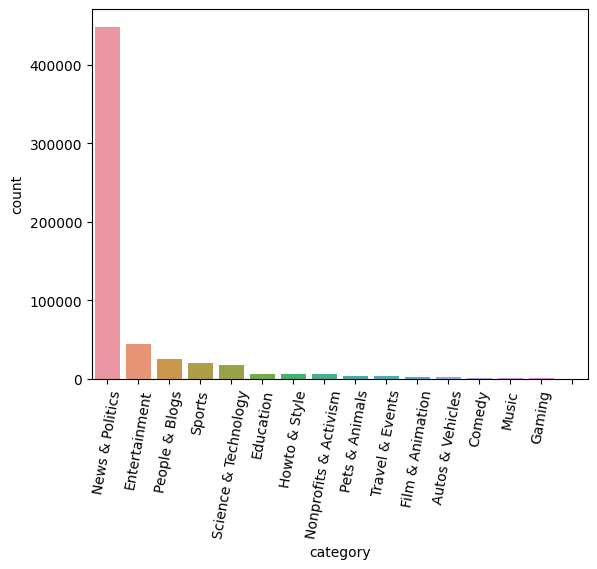

In [17]:
ax = sns.barplot(df_video_categories, x="category", y="count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

Let's look at what types of videos are left. As we see it is practically only New & Politics, which indicates that our matching generally worked.
After we manually review the matching of new outlets to channels we may consider dropping videos from other categories.

### Step 5
Filter comments of all relevant videos

In [18]:
# for now we are only interested in the video's ids
video_ids = set(df_videos.display_id)

In [19]:
del df_videos

In [20]:
# catch raw comments in this data structure
# we could optimize for low-memory machines by writing record-for-record to file directly at a later point
comments = []

We read comments in chunk. We skip running this cell, as it takes multiple hours. We have saved the results on disk.
Once we do the remaining filtering and data cleaning above we will re-run the computation.

In [21]:
i = 0
with pd.read_csv("data/youtube_comments.tsv.gz", sep="\t", chunksize=1000000) as df_stream:
  for df_comments_chunk in df_stream:
    i += 1
    # print(f"{i}/8606")

    comments.append(df_comments_chunk[df_comments_chunk.video_id.isin(video_ids)])

/tmp/ipykernel_3383/755746470.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_comments_chunk in df_stream:
/tmp/ipykernel_3383/755746470.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  for df_comments_chunk in df_stream:


In [22]:
# write intermediate result to file (expensive computation)
# with open("data/filtered_comments.pickle", "wb") as f:
#   pickle.dump(comments, f)

# continue from here
# with open("data/filtered_comments.pickle", "rb") as f:
#   comments = pickle.load(f)

In [23]:
df_comments = pd.concat(comments)
del comments
df_comments.to_csv("data/df_comments.csv.gz", index=False, compression="infer")

In [24]:
df_comments.head()

,author,video_id,likes,replies
897,24,G3RqyqYjNFg,0,0
1305,30,HqBtIWFW-0k,2,2
1306,30,HqBtIWFW-0k,0,0
2057,96,MGXSPf9b-xI,0,1
2082,97,n2ZEbfwfxKs,0,0


Next, we link each video with its channel, as ultimately, we aggregate by channel and not by video.

In [25]:
channel_ids = set(df_news.channel_id)

In [26]:
df_comments = df_comments.drop(["likes", "replies"], axis=1)

In [27]:
df_videos = pd.read_csv("data/df_videos.csv.gz")

In [28]:
df_comments_channels = pd.merge(df_videos[["channel_id", "display_id"]], df_comments, left_on="display_id", right_on="video_id", )

In [29]:
# free some memory
del df_comments
del df_videos

In [30]:
df_comments_channels.drop("display_id", axis=1, inplace=True)

In [31]:
df_comments_channels.to_csv("data/df_comments_channels.csv.gz", index=False, compression="infer")

### Step 6
Find common commenters and draw initial graph.

We create an edgelist of a graph. Each channel is a node. The edges are common commenters between videos of the corresponding channels. The edge weight is the count of commentors that commented on videos of both channels, i.e. the strength of the connection between two channels.

In [32]:
# This dictionary maps from combination of channels to a count of commenters
# We use an ordered tuple of channel IDs as key
c = dict()

def get_combinations_of_videos_per_commenter(commenter_group):
  """Computes pairwise combinations of channels for a given commenter
  """

  # Currently the weight is not increased if a user comments under multiple videos of both channels
  # We will review this, as it influences the final weight of the edges in our graph
  channels = commenter_group.channel_id.unique()

  # this only makes sense if a user commented under more than one video
  if len(channels) == 1:
    return

  channels.sort()

  # Get pairwise combinations  
  combs = combinations(channels, 2)
  for comb in combs:

    if not comb in c:
      c[comb] = 0

    c[comb] += 1

In [33]:
df_comments_channels = pd.read_csv("data/df_people_channel.csv.gz")

In [34]:
# aggregate comment data by comment author
df_comments_channels_grouped = df_comments_channels.groupby("author")
del df_comments_channels
# for each commenter update the edgelist and for any connection increase the weights
df_comments_channels_grouped.apply(get_combinations_of_videos_per_commenter)

""


In [35]:
del df_comments_channels_grouped

In [36]:
connections = [k+(v,) for k, v in c.items()]

df_graph = pd.DataFrame(connections, columns=["channel1", "channel2", "weight"])

df_graph.to_csv("data/df_graph.csv.gz", index=False, compression="infer")

Our preliminary edgelist comprises almost 14000 connections. It is quite the heavy-tailed distribution, let's see how the initial graph looks and then we decide if we want to use the log of commenter count as edge weights.

In [37]:
df_graph.head()

,channel1,channel2,weight
0,UC8p1vwvWtl6T73JiExfWs1g,UCBi2mrWuNuyYy4gbM6fU18Q,602201
1,UC8p1vwvWtl6T73JiExfWs1g,UCLXo7UDZvByw2ixzpQCufnA,203828
2,UC8p1vwvWtl6T73JiExfWs1g,UCiWLfSweyRNmLpgEHekhoAg,188184
3,UC8p1vwvWtl6T73JiExfWs1g,UCpVm7bg6pXKo1Pr6k5kxG9A,174999
4,UC8p1vwvWtl6T73JiExfWs1g,UCupvZG-5ko_eiXAupbDfxWw,557559


Text(0.5, 1.0, 'Distribution of weights (log weight)')

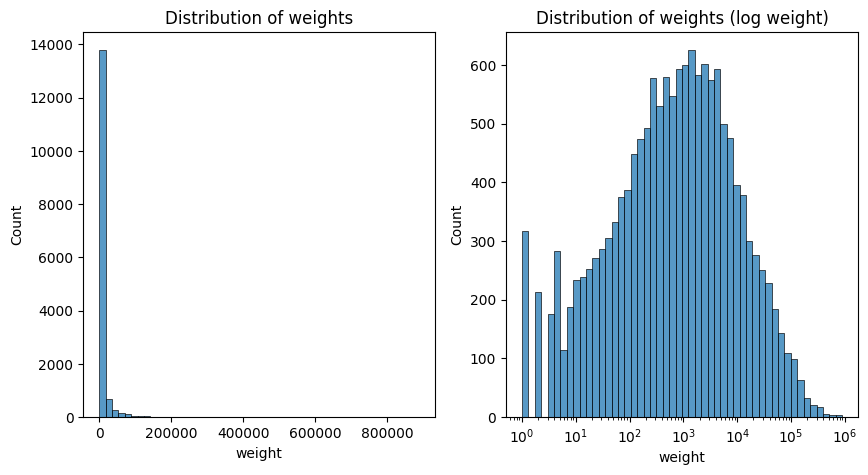

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(df_graph, bins=50, x="weight", log_scale=False, ax=axes[0]).set_title("Distribution of weights")
sns.histplot(df_graph, bins=50, x="weight", log_scale=True, ax=axes[1]).set_title("Distribution of weights (log weight)")

In [39]:
# get a final list (set) of channels in our graph
ch1 = set(df_graph.channel1.unique())
ch2 = set(df_graph.channel2.unique())
channels = ch1.union(ch2)

In [40]:
# we only include channels in the graph that has connections
# this decision is up for review later
df_channel_info = df_news[df_news.channel_id.isin(channels)][["channel_id", "channel_title", "media_bias_rating"]]

In [41]:
# we assign colors to each channel
colors = {
  "Right": "#de0100",
  "Lean Right": "#ff6766",
  "Center": "#808080",
  "Mixed": "#808080",
  "Lean Left": "#7669fc",
  "Left": "#1404bd" ,
}

#
df_channel_info["color"] = df_channel_info.media_bias_rating.apply(lambda rating: colors[rating])

In [42]:
# use network x to model our graph
G = nx.Graph()

In [43]:
# add all nodes
for _, channel in df_channel_info[df_channel_info.channel_id.isin(channels)].iterrows():
  G.add_node(
    channel.channel_id,
    title=channel.channel_title
  )

In [44]:
# add all edges including the weight
for idx, edge in df_graph.iterrows():
  G.add_edge(edge.channel1, edge.channel2, weight=edge.weight)

In [45]:
# to actually color the nodes in our graph we need to provide a separate color map
color_map = [list(df_channel_info[df_channel_info.channel_id == channel_id].color)[0] for channel_id in G]

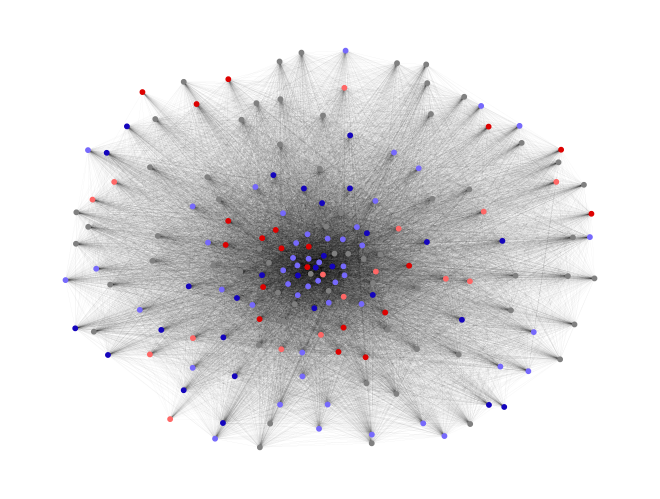

In [46]:
# draw graph, taking into account the channel weights
nx.draw(G,
  pos=nx.spring_layout(G,
                       seed=8,
                       k=30,
                       scale=1,
                       weight="weight"
                       ),
  node_size=10,
  node_color=color_map,
  width=0.01)

Our proof-of-concept worked!

# Part II: Time Series
### Step 1
   
Load datasets needed, YouNiverse time series and Trump approval time series.

In [3]:
df_news = pd.read_csv('data/df_news.csv.gz')
# YouNiverse time series
df_time = pd.read_csv('data/df_timeseries_en.tsv.gz', sep="\t", infer_datetime_format=True)
# Trump approval rate during time in office
df_polls_trump = pd.read_csv('data/trump_approval_polllist.csv')

### Step 2

Make DataFrames which have matching sampling frequency. Trump approval data has multiple datapoints per day, but the sampling frequency is not consistent. For Fox News the sampling is pretty consistent with one week per data point, so since Youtube data is the limiting factor, we resample both dataset according to that.

In [4]:
# Fox News Youtube channel
df_fox = df_time[df_time.channel=='UCCXoCcu9Rp7NPbTzIvogpZg'].copy() # Fox News channel id
df_fox['datetime'] = pd.to_datetime(df_fox['datetime']) # Correct time measure
a = df_fox['delta_views']
df_fox['delta_views'] = (a-a.mean())/a.std() # Standardise the data
df_fox = df_fox[['datetime','delta_views']]

# Choose data from January 2017 on, because poll data begins only then
df_fox=df_fox.loc[df_fox.datetime > np.datetime64('2017-01-15')]
df_fox.tail()

,datetime,delta_views
18533875,2019-09-02,1.805587
18533876,2019-09-09,1.342573
18533877,2019-09-16,1.490632
18533878,2019-09-23,2.780650
18533879,2019-09-30,2.464196


In [5]:
# Resample Trump approval to weekly averages

df = df_polls_trump[['startdate', 'adjusted_approve']].copy()
df = df.assign(Weeks = df['startdate']).drop(columns = 'startdate')
df['Weeks'] = pd.to_datetime(df['Weeks']) # Correct time measure

method = df.resample('W', label='left', closed = 'left', on='Weeks').mean()
df_trump = method.reset_index()

# Standardisation of data
df_trump['adjusted_approve'] = (df_trump['adjusted_approve']-df_trump['adjusted_approve'].mean())/df_trump['adjusted_approve'].std()
df_trump = df_trump.loc[df_trump.Weeks < np.datetime64('2019-10-01')]
df_trump.head()

,Weeks,adjusted_approve
0,2017-01-15,1.182511
1,2017-01-22,2.640689
2,2017-01-29,2.299543
3,2017-02-05,1.713444
4,2017-02-12,1.000237


In [6]:
# Resample Youtube data similarly to match dates with the the data frame

df = df_fox[['datetime', 'delta_views']].copy()
df = df.assign(Weeks = df['datetime']).drop(columns = 'datetime')
df['Weeks'] = pd.to_datetime(df['Weeks']) # Correct time measure

method = df.resample('W', label='left', closed = 'left', on='Weeks').mean()
df_fox_res = method.reset_index()

# Standardisation of data
df_fox_res['delta_views'] = (df_fox_res['delta_views']-df_fox_res['delta_views'].mean())/df_fox_res['delta_views'].std()
df_fox_res['delta_views'] = df_fox_res['delta_views'].fillna(method='ffill').values # FILL NAN GAPS
df_fox_res.head()

,Weeks,delta_views
0,2017-01-15,-0.342650
1,2017-01-22,-0.252376
2,2017-01-29,-1.529397
3,2017-02-05,-0.938137
4,2017-02-12,-0.836680


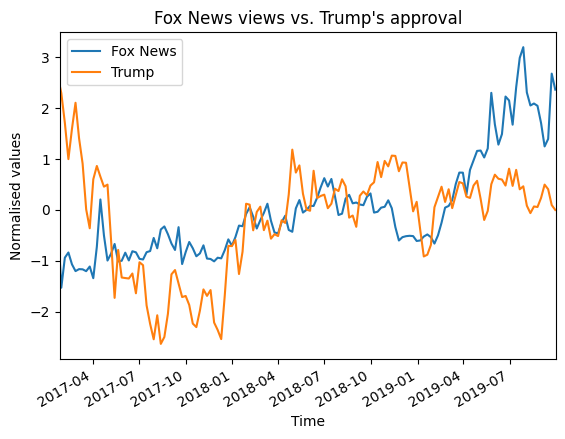

In [7]:
fig, ax = plt.subplots()
ax.plot(df_fox_res.Weeks, df_fox_res.delta_views)
ax.plot(df_trump.Weeks, df_trump.adjusted_approve)

fig.autofmt_xdate()
plt.title("Fox News views vs. Trump's approval")
ax.set_xlim([datetime.date(2017, 1, 26), datetime.date(2019, 9, 30)])
plt.ylabel('Normalised values')
plt.xlabel('Time')

ax.legend(['Fox News', 'Trump'])

In [8]:
# Pearson's correlation coefficient
np.corrcoef(df_trump['adjusted_approve'], df_fox_res['delta_views'])[0,1]

0.31718605742086364

### Step 3

Here we group the dataset based on whether a channel has political bias towards right or left. We also plotted the weekly viewing evolution during the time period.

In [10]:
# Choose channels of interest with earlier deefined df_time
# Intersect by channel id
df_time = df_time.rename(columns={'channel': 'channel_id'}) # matching column names
df_timeseries = df_time.merge(df_news)

In [11]:
# Devide the time series set according to political bias
mb = df_timeseries['media_bias_rating']
df_left = df_timeseries[(mb=='Lean Left') | (mb== 'Left')]
df_right = df_timeseries[(mb=='Lean Right') | (mb== 'Right')]

In [12]:
# Right and left viewings weekly similarly as before

df_l = df_left[['datetime', 'delta_views']].copy()
df_r = df_right[['datetime', 'delta_views']].copy()

df_l = df_l.assign(Weeks = df_l['datetime']).drop(columns = 'datetime')
df_r = df_r.assign(Weeks = df_r['datetime']).drop(columns = 'datetime')

df_l['Weeks'] = pd.to_datetime(df_l['Weeks']) # Correct time measure
df_r['Weeks'] = pd.to_datetime(df_r['Weeks']) # Correct time measure

method_l = df_l.resample('W', label='left', closed = 'left', on='Weeks').mean()
method_r = df_r.resample('W', label='left', closed = 'left', on='Weeks').mean()

df_left_weekly = method_l.reset_index()
df_right_weekly = method_r.reset_index()


df_left_weekly['delta_views'] = df_left_weekly['delta_views'].fillna(method='ffill').values # FILL NAN GAPS
df_right_weekly['delta_views'] = df_right_weekly['delta_views'].fillna(method='ffill').values # FILL NAN GAPS

# Standardisation of data
df_left_weekly['delta_views'] = (df_left_weekly['delta_views']-df_left_weekly['delta_views'].mean())/df_left_weekly['delta_views'].std()
df_right_weekly['delta_views'] = (df_right_weekly['delta_views']-df_right_weekly['delta_views'].mean())/df_right_weekly['delta_views'].std()


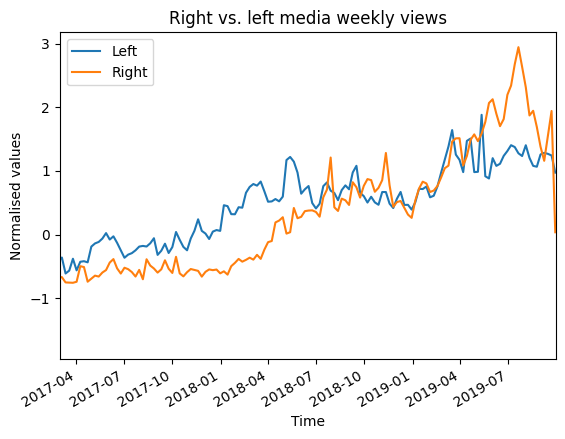

In [13]:
fig, ax = plt.subplots()
ax.plot(df_left_weekly.Weeks, df_left_weekly.delta_views)
ax.plot(df_right_weekly.Weeks, df_right_weekly.delta_views)

fig.autofmt_xdate()
plt.title("Right vs. left media weekly views")
ax.set_xlim([datetime.date(2017, 3, 1), datetime.date(2019, 9, 30)])
plt.ylabel('Normalised values')
plt.xlabel('Time')
ax.legend(['Left', 'Right'])